In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import (adjusted_rand_score, 
                             silhouette_score, 
                             normalized_mutual_info_score)
from sklearn.decomposition import PCA

# Clustering Blood Biomarkers to Identify Patients at Risk of Diabetes

## Introduction + Goal 

Diabetes is a chronic condition where the body cannot properly regulate blood sugar, and it can lead to serious complications if left untreated. Risk for diabetes is influenced by many biological factors, including age, weight, cholesterol levels, and kidney function.

**The goal of this project is to cluster patients using clinical data to identify patterns associated with diabetes.** The models I’ll be using are K-Means and Spectral Clustering. Each model will group patients based on their health features without using the diagnosis labels, allowing us to see if the clusters correspond to diabetic and non-diabetic patients.

The process will be as follows: first, preprocess and standardize the data, then fit both clustering algorithms and visualize the resulting clusters using PCA. Next, evaluate and compare the models using both internal and external metrics, such as silhouette score, ARI, and NMI. Finally, interpret the results to determine whether these unsupervised methods could be useful for identifying patients at risk of developing diabetes.

## Data Description + Preprocessing 

The dataset used in this project is from Kaggle and contains information on patients with clinical measurements related to cardiovascular and kidney health. Each of the 5132 rows represents one patient, and each of the 9 columns provides a biological or clinical feature:

- Age
- Gender 
- BMI 
- Chol 
- TG: triglyceride level in blood
- HDL: high-density lipoprotein (“good” cholesterol)
- LDL: low-density lipoprotein (“bad” cholesterol)
- Cr: creatinine level; indicative of kidney function
- BUN: blood urea nitrogen; indicative of kidney and liver function

The Diagnosis column indicates whether a patient has diabetes (1) or not (0). This column will not be used to train the clustering models but will be used to evaluate the results.

Learn more about the data [here](https://www.kaggle.com/datasets/simaanjali/diabetes-classification-dataset).

In [199]:
df = pd.read_csv('Diabetes.csv', index_col = 0)
df.head()

,Age,Gender,BMI,Chol,TG,HDL,LDL,Cr,BUN,Diagnosis
0,50,F,24,4.2,0.9,2.4,1.4,46.0,4.7,0
1,26,M,23,3.7,1.4,1.1,2.1,62.0,4.5,0
2,33,M,21,4.9,1.0,0.8,2.0,46.0,7.1,0
3,45,F,21,2.9,1.0,1.0,1.5,24.0,2.3,0
4,50,F,24,3.6,1.3,0.9,2.1,50.0,2.0,0


In [200]:
y.sum() / y.count()

0.38834762275915824

~39% of the patients in the dataset are diabetic, so the groups are uneven. This will be important when evaluating model fit. 

In [201]:
df.isna().sum()

Age          0
Gender       0
BMI          0
Chol         0
TG           0
HDL          0
LDL          0
Cr           0
BUN          0
Diagnosis    0
dtype: int64

In [202]:
df.dtypes

Age            int64
Gender        object
BMI            int64
Chol         float64
TG           float64
HDL          float64
LDL          float64
Cr           float64
BUN          float64
Diagnosis      int64
dtype: object

All the features are numeric and there is no missing data, so it is ready to be pre-processed.

First, I'm going to separate the training data from the true labels so learning is unsupervised. I'm also going to remove Gender as a predictor since it categorical and not meaningful when numerically-encoded. Next, I'm going to scale the features so each one contributes equally during clustering. Lastly, I'll use PCA to reduce the dimensionality of the dataset for plotting purposes. 

In [203]:
X = df.drop(['Gender', 'Diagnosis'], axis = 1)
y = df['Diagnosis']

In [204]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [205]:
pca = PCA(n_components = 2, random_state = 33)
X_pca = pca.fit_transform(X_scaled)

## Analysis 

Before training, I want to visualize the true clusters. 

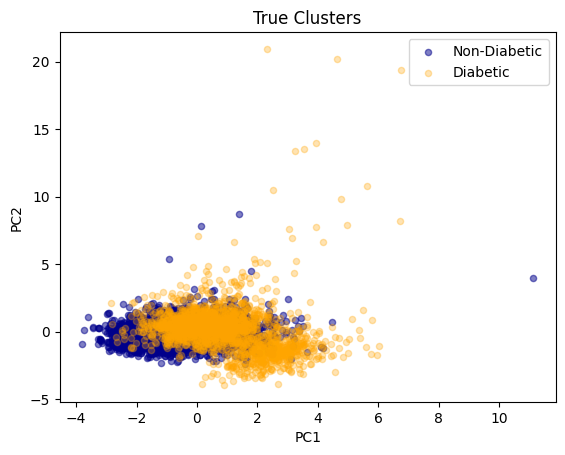

In [206]:
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], 
            c = 'darkblue', s = 20, alpha = 0.5, 
            label = 'Non-Diabetic')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], 
                c = 'orange', s = 20, alpha = 0.3, 
               label = 'Diabetic')
plt.title('True Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();

The clusters have quite a lot of overlap around the center (0,0), so we'll see if the separation along PC1 is signifigant enough for the clustering algorithms to pick up. 

### Algorithm 1: K-means

K-Means is a partition-based clustering algorithm that works by assigning each data point to the nearest cluster centroid, then updating the centroids iteratively until the assignments no longer change. The algorithm assumes that clusters are roughly spherical, have similar size and density, and are separable in the feature space. In this project, K-Means makes sense as a starting point because the clinical features are all continuous numeric values, and there are two natural groups in the data: diabetic and non-diabetic patients. Using K-Means provides a simple baseline to see if these two groups can be distinguished based purely on the patients’ biomarkers.

In [207]:
km = KMeans(n_clusters = 2, random_state = 33)
km_preds = km.fit_predict(X_scaled)

In [208]:
def checkPreds(preds):
    """
    Checks if the labels were flipped during fitting 
    Returns correct label assignments 
    """
    acc = accuracy_score(y, preds)
    acc2 = accuracy_score(y, 1-preds)
    if accuracy_score(y, preds) >= accuracy_score(y, 1-preds):
        return preds 
    return 1-preds

km_preds = checkPreds(km_preds)

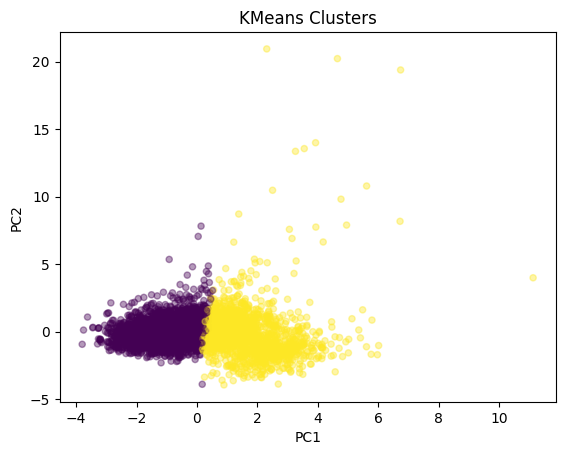

In [209]:
def plotClusters(preds, title):
    """
    Helper function to plot clusters in pca-transformed space
    """
    plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                c = preds, s = 20, alpha = 0.4)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

plotClusters(km_preds, 'KMeans Clusters')

The K-Means clusters are separated roughly straight down the middle along PC1 = 0, with the two groups appearing fairly even in size. This aligns with the algorithm’s tendency to find spherical, similarly sized clusters, and suggests that it is primarily using the strongest linear separation in the data to assign patients to clusters.

### Algorithm 2: Spectral Clustering

Spectral Clustering is a graph-based clustering algorithm that first constructs a similarity graph between data points, often using nearest neighbors, and then computes a low-dimensional embedding from the graph’s eigenvectors. The final clusters are obtained by running K-Means on this transformed space. Unlike K-Means, Spectral Clustering does not assume that clusters are spherical or of similar size, which allows it to capture more complex or irregular cluster shapes. In this project, Spectral Clustering is useful because the PCA plot suggests some overlap in the center of the data, so a method that considers the connectivity and overall structure of the points may be able to separate diabetic and non-diabetic patients more effectively.

In [ ]:
sc = SpectralClustering(n_clusters = 2, 
                        affinity='nearest_neighbors', 
                        random_state = 33)
sc_preds = sc.fit_predict(X_scaled)
sc_preds = checkPreds(sc_preds)
plotClusters(sc_preds, 'Spectral Clusters')

Compared to Kmeans, the Spectral clusters show a different pattern. The clusters are not aligned along a single principal component and the group sizes appear very uneven. This reflects SC’s ability to capture more complex structures in the data.

### Performance Metrics

To evaluate the clustering results, I’ll use a combination of internal and external metrics. 
- The **silhouette score** is an internal metric that measures how well each point fits within its assigned cluster compared to other clusters, with higher values indicating more well-separated clusters. Since we also have the true diabetes labels, I can use external metrics to see how well the clusters correspond to actual patient outcomes.
- The **Adjusted Rand Index (ARI)** measures the similarity between the predicted clusters and the true labels while correcting for chance, making it especially useful when group sizes are uneven.
- Similarly to ARI, **Normalized Mutual Information (NMI)** quantifies the shared information between the clusters and the true labels, providing a normalized measure of agreement.

Together, these metrics allow me to assess both the quality of the clusters in the feature space and their relevance to predicting diabetes.

In [ ]:
km_sil = silhouette_score(X_scaled, km_preds)
km_ari = adjusted_rand_score(y, km_preds)
km_nmi = normalized_mutual_info_score(y, km_preds)

sc_sil = silhouette_score(X_scaled, sc_preds)
sc_ari = adjusted_rand_score(y, sc_preds)
sc_nmi = normalized_mutual_info_score(y, sc_preds)

metrics = pd.DataFrame([{'Model': 'KM', 'SIL': km_sil, 'ARI': km_ari, 'NMI': km_nmi}, 
                        {'Model': 'Spectral','SIL': sc_sil, 'ARI': sc_ari, 'NMI': sc_nmi}])
metrics

## Results 

Based on the plots and evaluation metrics, the two algorithms captured different aspects of the data, but neither produced clusters that perfectly correspond to diabetes status.

K-Means produced two fairly even clusters separated along PC1 = 0, which aligns with its assumptions of spherical and similarly sized clusters. The silhouette score of 0.227 indicates that the clusters are moderately cohesive, while the ARI (0.178) and NMI (0.116) suggest a weak correspondence between the clusters and the true diabetes labels. This implies that K-Means is largely capturing the overall linear separation in the data but is not reliably identifying diabetic patients.

On the other hand, Spectral Clustering generated clusters that were uneven in size and not aligned along a principal component. Its higher silhouette score (0.390) shows that the clusters are internally more cohesive in the transformed space, but the ARI (0.117) indicates that this structure does not match the true labels well. From the plots, it appears that SC tends to identify diabetic patients with extreme biomarker values while missing those with more average values. 

## Conclusion 

Overall, these results suggest that while clustering can reveal patterns in patient biomarker data, unsupervised methods like K-Means and Spectral Clustering are not particularly effective at identifying diabetes across all patients. The clusters do not reliably separate diabetic and non-diabetic patients, likely because the groups overlap in the feature space and do not form distinct shapes that these algorithms assume. However, Spectral Clustering appears to capture patients with more extreme biomarker values, which could make it useful for identifying high-risk or clearly diabetic patients, even if it fails to detect those with more borderline or average values. For general prediction of diabetes, supervised methods trained on the diagnosis labels might still provide more accurate results, but clustering could offer some value for flagging the highest-risk cases.